# Capsule Networks (CapsNets)

This is the [Aurélien Géron's](https://github.com/ageron/handson-ml/blob/master/extra_capsnets.ipynb) implementation with aditional comments and some modifications that I've done due to tensorflow and imports versions. I implemented the code using graph mode. In a future version I will update to use eager mode.

Based on the paper: [Dynamic Routing Between Capsules](https://arxiv.org/abs/1710.09829), by Sara Sabour, Nicholas Frosst and Geoffrey E. Hinton (NIPS 2017).

Inspired in part from Huadong Liao's implementation: [CapsNet-TensorFlow.](https://github.com/naturomics/CapsNet-Tensorflow)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Found GPU at: /device:GPU:0


# Introduction

[This video](https://youtu.be/pPN8d0E3900) explain the key ideas behind Capsule Networks:

In [2]:
from IPython.display import HTML
HTML("""<iframe width="560" height="315" src="https://www.youtube.com/embed/pPN8d0E3900" frameborder="0" allowfullscreen></iframe>""")

/opt/conda/lib/python3.10/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


[This video](https://youtu.be/2Kawrd5szHE) presents the main difficulties of this notebook:

In [3]:
HTML("""<iframe width="560" height="315" src="https://www.youtube.com/embed/2Kawrd5szHE" frameborder="0" allowfullscreen></iframe>""")

# Imports

To support both Python 2 and Python 3:

In [4]:
from __future__ import division, print_function, unicode_literals

Import matplotlib to plot pretty figures:

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [6]:
import tensorflow as tf
print(tf.__version__)

2.13.0


## Reproducibility

Let's reset the default graph, in case you re-run this notebook without restarting the kernel:

In [7]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

Let's set the random seeds so that this notebook always produces the same output:

In [8]:
np.random.seed(42)
tf.random.set_seed(45)

# Load Dataset

In [9]:
import os
import cv2

train_path = '/kaggle/input/dataset_new/train'
test_path = '/kaggle/input/dataset_new/test'

train_classes = os.listdir(train_path)
test_classes = os.listdir(test_path)

img_size = 32
no_channel = 3

X_train = []
y_train = []
for label in train_classes:
    data_path = os.path.join(train_path, label)
    class_num = train_classes.index(label)
    for img in os.listdir(data_path):
            try:
                img_arr = cv2.imread(os.path.join(data_path, img))[...,::-1]
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                X_train.append(resized_arr)
                y_train.append(class_num)
            except Exception as e:
                print(e)
                
X_test = []
y_test = []
for label in test_classes:
    data_path = os.path.join(test_path, label)
    class_num = test_classes.index(label)
    for img in os.listdir(data_path):
            try:
                img_arr = cv2.imread(os.path.join(data_path, img))[...,::-1]
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                X_test.append(resized_arr)
                y_test.append(class_num)
            except Exception as e:
                print(e)

In [10]:
X_train = np.array(X_train)
X_train = X_train.reshape(-1, img_size, img_size, no_channel).astype('float32') / 255.

X_test = np.array(X_test)
X_test = X_test.reshape(-1, img_size, img_size, no_channel).astype('float32') / 255.

In [11]:
X_train.shape

(2467, 32, 32, 3)

In [12]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [13]:
y_train.shape

(2467,)

Let's look at what these image data look like:

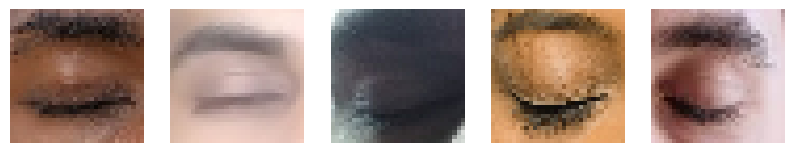

In [14]:
n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = X_train[index].reshape(img_size, img_size, no_channel)
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")

plt.show()

And these are the corresponding labels:

In [15]:
y_train[:n_samples]

array([0, 0, 0, 0, 0])

Now let's build a Capsule Network to classify these images. Here's the overall architecture, enjoy the ASCII art! ;-) Note: for readability, I left out two arrows: Labels → Mask, and Input Images → Reconstruction Loss.
 

                            Loss
                              ↑
                    ┌─────────┴─────────┐
      Labels → Margin Loss      Reconstruction Loss
                    ↑                   ↑
                  Length             Decoder
                    ↑                   ↑ 
             Digit Capsules ────Mask────┘
               ↖↑↗ ↖↑↗ ↖↑↗
             Primary Capsules
                    ↑      
               Input Images


We are going to build the graph starting from the bottom layer, and gradually move up, left side first. Let's go!

# Input Images

Let's start by creating a placeholder for the input images (32×32 pixels, 3 color channel = RGB).

In [16]:
tf.compat.v1.disable_eager_execution()
X = tf.compat.v1.placeholder(shape=[None, img_size, img_size, no_channel], dtype=tf.float32, name="X")

Note1: [check in this link why I disabled eager execution](https://stackoverflow.com/questions/56561734/runtimeerror-tf-placeholder-is-not-compatible-with-eager-execution) <br>
Note2: [What tf.compat means](https://stackoverflow.com/questions/60406140/attributeerror-module-tensorflow-has-no-attribute-layers)

# Primary Capsules

The first layer will be composed of 32 maps of 5×5 capsules each, where each capsule will output an 8D activation vector:

In [17]:
caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 5 * 5  # 800 primary capsules
caps1_n_dims = 8

To compute their outputs, we first apply two regular convolutional layers:

In [18]:
conv1_params = {
    "filters": 256,
    "kernel_size": 6,
    "strides": 2,
    "padding": "valid",
    "activation": tf.nn.relu,
}
conv1 = tf.compat.v1.layers.conv2d(X, name="conv1", **conv1_params)

/tmp/ipykernel_301/949659308.py:8: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv1 = tf.compat.v1.layers.conv2d(X, name="conv1", **conv1_params)


In [19]:
conv2_params = {
    "filters": caps1_n_maps * caps1_n_dims, # 256 convolutional filters,
    "kernel_size": 6,
    "strides": 2,
    "padding": "valid",
    "activation": tf.nn.relu,
}
conv2 = tf.compat.v1.layers.conv2d(conv1, name="conv2", **conv2_params)

/tmp/ipykernel_301/2861925222.py:8: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv2 = tf.compat.v1.layers.conv2d(conv1, name="conv2", **conv2_params)


To calculate the output shape, we use: <br>

$\operatorname{output shape} = \biggl(\dfrac{\operatorname{input shape} - \operatorname{number of kernels} + 2 \times \operatorname{padding}}{\operatorname{number of strides}} + 1, \dfrac{\operatorname{input shape} - \operatorname{number of kernels} + 2 \times \operatorname{padding}}{\operatorname{number of strides}} + 1\biggr)$. So, we get: <br>

$\operatorname{output shape of the 1st layer} = \biggl(\dfrac{32 - 6 + 2 \times 0}{2} + 1, \dfrac{32 - 6 + 2 \times 0}{2} + 1\biggr) = \biggl(\dfrac{26}{2} + 1, \dfrac{26}{2} + 1\biggr) = (13 + 1, 13 + 1) = (14, 14)$ <br>

$\operatorname{output shape of the 2nd layer} = \biggl(\dfrac{14 - 6 + 2 \times 0}{2} + 1, \dfrac{14 - 6 + 2 \times 0}{2} + 1\biggr) = \biggl(\dfrac{8}{2} + 1, \dfrac{8}{2} + 1\biggr) = (4 + 1, 4 + 1) = (5, 5)$ <br>

This is how we end up with 5×5 feature maps.

Next, we reshape the output to get a bunch of 8D vectors representing the outputs of the primary capsules. The output of conv2 is an array containing 32×8=256 feature maps for each instance, where each feature map is 5×5. So the shape of this output is (batch size, 5, 5, 256). We want to chop the 256 into 32 vectors of 8 dimensions each. We could do this by reshaping to (batch size, 5, 5, 32, 8). However, since this first capsule layer will be fully connected to the next capsule layer, we can simply flatten the 5×5 grids. This means we just need to reshape to (batch size, 5×5×32, 8).

In [20]:
caps1_raw = tf.reshape(conv2, [-1, caps1_n_caps, caps1_n_dims],
                       name="caps1_raw")

Now we need to squash these vectors. Let's define the squash() function, based on equation (1) from the paper:

$\operatorname{squash}(\mathbf{s}) = \dfrac{\|\mathbf{s}\|^2}{1 + \|\mathbf{s}\|^2} \dfrac{\mathbf{s}}{\|\mathbf{s}\|}$

The squash() function will squash all vectors in the given array, along the given axis (by default, the last axis).

Caution, a nasty bug is waiting to bite you: the derivative of $\|\mathbf{s}\|$ is undefined when $\|\mathbf{s}\|=0$, so we can't just use tf.norm(), or else it will blow up during training: if a vector is zero, the gradients will be nan, so when the optimizer updates the variables, they will also become nan, and from then on you will be stuck in nan land. The solution is to implement the norm manually by computing the square root of the sum of squares plus a tiny epsilon value: $\|\mathbf{s}\| \approx \sqrt{\sum\limits_i{{s_i}^2}\,\,+ \epsilon}$.

In [21]:
def squash(s, axis=-1, epsilon=1e-7, name=None):
    with tf.name_scope(name):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keepdims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector

Now let's apply this function to get the output $\mathbf{u}_i$ of each primary capsules $i$ :

In [22]:
caps1_output = squash(caps1_raw, name="caps1_output")

Great! We have the output of the first capsule layer. It wasn't too hard, was it? However, computing the next layer is where the fun really begins.

# Digit Capsules

To compute the output of the digit capsules, we must first compute the predicted output vectors (one for each primary / digit capsule pair). Then we can run the routing by agreement algorithm.

## Compute the Predicted Output Vectors

The digit capsule layer contains 4 capsules (one for each digit) of 16 dimensions each:

In [23]:
caps2_n_caps = 4
caps2_n_dims = 16

For each capsule $i$ in the first layer, we want to predict the output of every capsule $j$ in the second layer. For this, we will need a transformation matrix $\mathbf{W}_{i,j}$ (one for each pair of capsules ($i$, $j$)), then we can compute the predicted output $\hat{\mathbf{u}}_{j|i} = \mathbf{W}_{i,j} \, \mathbf{u}_i$ (equation (2)-right in the paper). Since we want to transform an 8D vector into a 16D vector, each transformation matrix $\mathbf{W}_{i,j}$ must have a shape of (16, 8).

To compute $\hat{\mathbf{u}}_{j|i}$ for every pair of capsules ($i$, $j$), we will use a nice feature of the tf.matmul() function: you probably know that it lets you multiply two matrices, but you may not know that it also lets you multiply higher dimensional arrays. It treats the arrays as arrays of matrices, and it performs itemwise matrix multiplication. For example, suppose you have two 4D arrays, each containing a 2×3 grid of matrices. The first contains matrices $\mathbf{A}, \mathbf{B}, \mathbf{C}, \mathbf{D}, \mathbf{E}, \mathbf{F}$ and the second contains matrices $\mathbf{G}, \mathbf{H}, \mathbf{I}, \mathbf{J}, \mathbf{K}, \mathbf{L}$. If you multiply these two 4D arrays using the tf.matmul() function, this is what you get:

$\pmatrix{\mathbf{A} & \mathbf{B} & \mathbf{C} \\ \mathbf{D} & \mathbf{E} & \mathbf{F} } \times \pmatrix{ \mathbf{G} & \mathbf{H} & \mathbf{I} \\ \mathbf{J} & \mathbf{K} & \mathbf{L} } = \pmatrix{ \mathbf{AG} & \mathbf{BH} & \mathbf{CI} \\ \mathbf{DJ} & \mathbf{EK} & \mathbf{FL}}$

We can apply this function to compute $\hat{\mathbf{u}}_{j|i}$ for every pair of capsules ($i$, $j$) like this (recall that there are 9×9×32=2592 capsules in the first layer, and 4 in the second layer):

$\pmatrix{\mathbf{W}_{1,1} & \mathbf{W}_{1,2} & \mathbf{W}_{1,3} & \mathbf{W}_{1,4} \ \mathbf{W}_{2,1} & \mathbf{W}_{2,2} & \mathbf{W}_{2,4} & \mathbf{W}_{2,4} \ \vdots & \vdots & \ddots & \vdots \ \mathbf{W}_{800,1} & \mathbf{W}_{800,2} & \mathbf{W}_{800,3} & \mathbf{W}_{800,4} } \times \pmatrix{ \mathbf{u}_1 & \mathbf{u}_1 & \mathbf{u}_1 & \mathbf{u}_1 \ \mathbf{u}_2 & \mathbf{u}_2 & \mathbf{u}_2 & \mathbf{u}_2 \ \vdots & \vdots & \ddots & \vdots \ \mathbf{u}_{800} & \mathbf{u}_{800} & \mathbf{u}_{800} & \mathbf{u}_{800}}$

$\pmatrix{\hat{\mathbf{u}}_{1|1} & \hat{\mathbf{u}}_{2|1} & \hat{\mathbf{u}}_{3|1} & \hat{\mathbf{u}}_{4|1} \ \hat{\mathbf{u}}_{1|2} & \hat{\mathbf{u}}_{2|2} & \hat{\mathbf{u}}_{3|2} & \hat{\mathbf{u}}_{4|2} \ \vdots & \vdots & \ddots & \vdots \ \hat{\mathbf{u}}_{1|800} & \hat{\mathbf{u}}_{2|800} & \hat{\mathbf{u}}_{3|800} & \hat{\mathbf{u}}_{4|800}}$

The shape of the first array is (800, 4, 16, 8), and the shape of the second array is (800, 4, 8, 1). Note that the second array must contain 4 identical copies of the vectors $\mathbf{u}_1$ to $\mathbf{u}_{800}$. To create this array, we will use the handy tf.tile() function, which lets you create an array containing many copies of a base array, tiled in any way you want.

Oh, wait a second! We forgot one dimension: batch size. Say we feed 50 images to the capsule network, it will make predictions for these 50 images simultaneously. So the shape of the first array must be (50, 800, 4, 16, 8), and the shape of the second array must be (50, 800, 4, 8, 1). The first layer capsules actually already output predictions for all 50 images, so the second array will be fine, but for the first array, we will need to use tf.tile() to have 50 copies of the transformation matrices.

Okay, let's start by creating a trainable variable of shape (1, 800, 4, 16, 8) that will hold all the transformation matrices. The first dimension of size 1 will make this array easy to tile. We initialize this variable randomly using a normal distribution with a standard deviation to 0.1.

In [24]:
init_sigma = 0.1

W_init = tf.random.normal(
    shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),
    stddev=init_sigma, dtype=tf.float32, name="W_init")
W = tf.Variable(W_init, name="W")

Now we can create the first array by repeating W once per instance:

In [25]:
batch_size = tf.shape(X)[0]
W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_tiled")

That's it! On to the second array, now. As discussed earlier, we need to create an array of shape (batch size, 800, 4, 8, 1), containing the output of the first layer capsules, repeated 4 times (once per digit, along the third dimension, which is axis=2). The caps1_output array has a shape of (batch size, 800, 8), so we first need to expand it twice, to get an array of shape (batch size, 800, 1, 8, 1), then we can repeat it 4 times along the third dimension:

In [26]:
caps1_output_expanded = tf.expand_dims(caps1_output, -1,
                                       name="caps1_output_expanded")
caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2,
                                   name="caps1_output_tile")
caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps, 1, 1],
                             name="caps1_output_tiled")

Let's check the shape of the first array:

In [27]:
W_tiled

<tf.Tensor 'W_tiled:0' shape=(None, 800, 4, 16, 8) dtype=float32>

Yes! Now, to get all the predicted output vectors $\hat{\mathbf{u}}_{j|i}$, we just need to multiply these two arrays using tf.matmul(), as explained earlier:

In [28]:
caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled,
                            name="caps2_predicted")

Let's check the shape:

In [29]:
caps2_predicted

<tf.Tensor 'caps2_predicted:0' shape=(None, 800, 4, 16, 1) dtype=float32>

Perfect, for each instance in the batch (we don't know the batch size yet, hence the "?") and for each pair of first and second layer capsules (800×4) we have a 16D predicted output column vector (16×1). We're ready to apply the routing by agreement algorithm!

# Routing by agreement

First let's initialize the raw routing weights $b_{i,j}$ to zero:

In [30]:
raw_weights = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps, 1, 1],
                       dtype=np.float32, name="raw_weights")

We will see why we need the last two dimensions of size 1 in a minute.

## Round 1

First, let's apply the softmax function to compute the routing weights, $\mathbf{c}_{i} = \operatorname{softmax}(\mathbf{b}_i)$ (equation (3) in the paper):

In [31]:
routing_weights = tf.nn.softmax(raw_weights, name="routing_weights")

Now let's compute the weighted sum of all the predicted output vectors for each second-layer capsule, $\mathbf{s}_j = \sum\limits_{i}{c_{i,j}\hat{\mathbf{u}}_{j|i}}$ (equation (2)-left in the paper):

In [32]:
weighted_predictions = tf.multiply(routing_weights, caps2_predicted,
                                   name="weighted_predictions")
weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keepdims=True,
                             name="weighted_sum")

There are a couple important details to note here:

To perform elementwise matrix multiplication (also called the Hadamard product, noted $\circ$), we use the tf.multiply() function. It requires routing_weights and caps2_predicted to have the same rank, which is why we added two extra dimensions of size 1 to routing_weights, earlier.

The shape of routing_weights is (batch size, 800, 4, 1, 1) while the shape of caps2_predicted is (batch size, 800, 4, 16, 1). Since they don't match on the fourth dimension (1 vs 16), tf.multiply() automatically broadcasts the routing_weights 16 times along that dimension. If you are not familiar with broadcasting, a simple example might help:

$\pmatrix{1 & 2 & 3 \\ 4 & 5 & 6} \circ \pmatrix{10 & 100 & 1000} = \pmatrix{1 & 2 & 3 \\ 4 & 5 & 6} \circ \pmatrix{10 & 100 & 1000 \\ 10 & 100 & 1000} = \pmatrix{10 & 200 & 3000 \\ 40 & 500 & 6000}$

And finally, let's apply the squash function to get the outputs of the second layer capsules at the end of the first iteration of the routing by agreement algorithm, $\mathbf{v}_j = \operatorname{squash}(\mathbf{s}_j)$ :

In [33]:
caps2_output_round_1 = squash(weighted_sum, axis=-2,
                              name="caps2_output_round_1")

In [34]:
caps2_output_round_1

<tf.Tensor 'caps2_output_round_1/mul:0' shape=(None, 1, 4, 16, 1) dtype=float32>

Good! We have ten 16D output vectors for each instance, as expected.

## Round 2

First, let's measure how close each predicted vector $\hat{\mathbf{u}}_{j|i}$ is to the actual output vector $\mathbf{v}_j$ by computing their scalar product $\hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$.

Quick math reminder: if $\vec{a}$ and $\vec{b}$ are two vectors of equal length, and $\mathbf{a}$ and $\mathbf{b}$ are their corresponding column vectors (i.e., matrices with a single column), then $\mathbf{a}^T \mathbf{b}$ (i.e., the matrix multiplication of the transpose of $\mathbf{a}$, and $\mathbf{b}$) is a 1×1 matrix containing the scalar product of the two vectors $\vec{a}\cdot\vec{b}$. In Machine Learning, we generally represent vectors as column vectors, so when we talk about computing the scalar product $\hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$, this actually means computing ${\hat{\mathbf{u}}_{j|i}}^T \mathbf{v}_j$.

Since we need to compute the scalar product $\hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$ for each instance, and for each pair of first and second level capsules $(i, j)$, we will once again take advantage of the fact that tf.matmul() can multiply many matrices simultaneously. This will require playing around with tf.tile() to get all dimensions to match (except for the last 2), just like we did earlier. So let's look at the shape of caps2_predicted, which holds all the predicted output vectors $\hat{\mathbf{u}}_{j|i}$ for each instance and each pair of capsules:

In [35]:
caps2_predicted

<tf.Tensor 'caps2_predicted:0' shape=(None, 800, 4, 16, 1) dtype=float32>

And now let's look at the shape of caps2_output_round_1, which holds 4 outputs vectors of 16D each, for each instance:

In [36]:
caps2_output_round_1

<tf.Tensor 'caps2_output_round_1/mul:0' shape=(None, 1, 4, 16, 1) dtype=float32>

To get these shapes to match, we just need to tile the caps2_output_round_1 array 800 times (once per primary capsule) along the second dimension:

In [37]:
caps2_output_round_1_tiled = tf.tile(
    caps2_output_round_1, [1, caps1_n_caps, 1, 1, 1],
    name="caps2_output_round_1_tiled")

And now we are ready to call tf.matmul() (note that we must tell it to transpose the matrices in the first array, to get ${\hat{\mathbf{u}}_{j|i}}^T$ instead of $\hat{\mathbf{u}}_{j|i}$):

In [38]:
agreement = tf.matmul(caps2_predicted, caps2_output_round_1_tiled,
                      transpose_a=True, name="agreement")

We can now update the raw routing weights $b_{i,j}$ by simply adding the scalar product $\hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$ we just computed: $b_{i,j} \gets b_{i,j} + \hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$ (see Procedure 1, step 7, in the paper).

In [39]:
raw_weights_round_2 = tf.add(raw_weights, agreement,
                             name="raw_weights_round_2")

The rest of round 2 is the same as in round 1:

In [40]:
routing_weights_round_2 = tf.nn.softmax(raw_weights_round_2,
                                        name="routing_weights_round_2")
weighted_predictions_round_2 = tf.multiply(routing_weights_round_2,
                                           caps2_predicted,
                                           name="weighted_predictions_round_2")
weighted_sum_round_2 = tf.reduce_sum(weighted_predictions_round_2,
                                     axis=1, keepdims=True,
                                     name="weighted_sum_round_2")
caps2_output_round_2 = squash(weighted_sum_round_2,
                              axis=-2,
                              name="caps2_output_round_2")

We could go on for a few more rounds, by repeating exactly the same steps as in round 2, but to keep things short, we will stop here:

In [41]:
caps2_output = caps2_output_round_2

## Static or Dynamic Loop?

In the code above, we created different operations in the TensorFlow graph for each round of the routing by agreement algorithm. In other words, it's a static loop.

Sure, instead of copy/pasting the code several times, we could have written a for loop in Python, but this would not change the fact that the graph would end up containing different operations for each routing iteration. It's actually okay since we generally want less than 5 routing iterations, so the graph won't grow too big.

However, you may prefer to implement the routing loop within the TensorFlow graph itself rather than using a Python for loop. To do this, you would need to use TensorFlow's tf.while_loop() function. This way, all routing iterations would reuse the same operations in the graph, it would be a dynamic loop.

For example, here is how to build a small loop that computes the sum of squares from 1 to 100:

In [42]:
def condition(input, counter):
    return tf.less(counter, 100)

def loop_body(input, counter):
    output = tf.add(input, tf.square(counter))
    return output, tf.add(counter, 1)

with tf.name_scope("compute_sum_of_squares"):
    counter = tf.constant(1)
    sum_of_squares = tf.constant(0)

    result = tf.while_loop(condition, loop_body, [sum_of_squares, counter])
    
with tf.compat.v1.Session() as sess:
    print(sess.run(result))

[328350, 100]


As you can see, the tf.while_loop() function expects the loop condition and body to be provided via two functions. These functions will be called only once by TensorFlow, during the graph construction phase, not while executing the graph. The tf.while_loop() function stitches together the graph fragments created by condition() and loop_body() with some additional operations to create the loop.

Also note that during training, TensorFlow will automagically handle backpropogation through the loop, so you don't need to worry about that.

Of course, we could have used this one-liner instead! ;-)

In [43]:
sum([i**2 for i in range(1, 100 + 1)])

338350

Joke aside, apart from reducing the graph size, using a dynamic loop instead of a static loop can help reduce how much GPU RAM you use (if you are using a GPU). Indeed, if you set swap_memory=True when calling the tf.while_loop() function, TensorFlow will automatically check GPU RAM usage at each loop iteration, and it will take care of swapping memory between the GPU and the CPU when needed. Since CPU memory is much cheaper and abundant than GPU RAM, this can really make a big difference.

## Estimated Class Probabilities (Length)

The lengths of the output vectors represent the class probabilities, so we could just use tf.norm() to compute them, but as we saw when discussing the squash function, it would be risky, so instead let's create our own safe_norm() function:

In [44]:
def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keepdims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)

In [45]:
y_proba = safe_norm(caps2_output, axis=-2, name="y_proba")

To predict the class of each instance, we can just select the one with the highest estimated probability. To do this, let's start by finding its index using tf.argmax():

In [46]:
y_proba_argmax = tf.argmax(y_proba, axis=2, name="y_proba")

Let's look at the shape of y_proba_argmax:

In [47]:
y_proba_argmax

<tf.Tensor 'y_proba_1:0' shape=(None, 1, 1) dtype=int64>

That's what we wanted: for each instance, we now have the index of the longest output vector. Let's get rid of the last two dimensions by using tf.squeeze() which removes dimensions of size 1. This gives us the capsule network's predicted class for each instance:

In [48]:
y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")

In [49]:
y_pred

<tf.Tensor 'y_pred:0' shape=(None,) dtype=int64>

Okay, we are now ready to define the training operations, starting with the losses.

# Labels

First, we will need a placeholder for the labels:

In [50]:
y = tf.compat.v1.placeholder(shape=[None], dtype=tf.int64, name="y")

# Margin loss

The paper uses a special margin loss to make it possible to detect two or more different digits in each image:

$ L_k = T_k \max(0, m^{+} - \|\mathbf{v}_k\|)^2 + \lambda (1 - T_k) \max(0, \|\mathbf{v}_k\| - m^{-})^2$

$T_k$ is equal to 1 if the digit of class $k$ is present, or 0 otherwise.
In the paper, $m^{+} = 0.9$, $m^{-} = 0.1$ and $\lambda = 0.5$.
Note that there was an error in the video (at 15:47): the max operations are squared, not the norms. Sorry about that.

In [51]:
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

Since y will contain the digit classes, from 0 to 9, to get $T_k$ for every instance and every class, we can just use the tf.one_hot() function:

In [52]:
T = tf.one_hot(y, depth=caps2_n_caps, name="T")

A small example should make it clear what this does:

In [53]:
with tf.compat.v1.Session():
    print(T.eval(feed_dict={y: np.array([0, 1, 2, 3])}))

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


Now let's compute the norm of the output vector for each output capsule and each instance. First, let's verify the shape of caps2_output:

In [54]:
caps2_output

<tf.Tensor 'caps2_output_round_2/mul:0' shape=(None, 1, 4, 16, 1) dtype=float32>

The 16D output vectors are in the second to last dimension, so let's use the safe_norm() function with axis=-2:

In [55]:
caps2_output_norm = safe_norm(caps2_output, axis=-2, keep_dims=True,
                              name="caps2_output_norm")

Now let's compute $\max(0, m^{+} - \|\mathbf{v}_k\|)^2$, and reshape the result to get a simple matrix of shape (batch size, 4):

In [56]:
present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm),
                              name="present_error_raw")
present_error = tf.reshape(present_error_raw, shape=(-1, 4),
                           name="present_error")

Next let's compute $\max(0, \|\mathbf{v}_k\| - m^{-})^2$ and reshape it:

In [57]:
absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus),
                             name="absent_error_raw")
absent_error = tf.reshape(absent_error_raw, shape=(-1, 4),
                          name="absent_error")

We are ready to compute the loss for each instance and each digit:

In [58]:
L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error,
           name="L")

Now we can sum the digit losses for each instance ($L_0 + L_1 + \cdots + L_9$), and compute the mean over all instances. This gives us the final margin loss:

In [59]:
margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")

# Reconstruction

Now let's add a decoder network on top of the capsule network. It is a regular 3-layer fully connected neural network which will learn to reconstruct the input images based on the output of the capsule network. This will force the capsule network to preserve all the information required to reconstruct the digits, across the whole network. This constraint regularizes the model: it reduces the risk of overfitting the training set, and it helps generalize to new digits.

## Mask

The paper mentions that during training, instead of sending all the outputs of the capsule network to the decoder network, we must send only the output vector of the capsule that corresponds to the target digit. All the other output vectors must be masked out. At inference time, we must mask all output vectors except for the longest one, i.e., the one that corresponds to the predicted digit. You can see this in the paper's figure 2 (at 18:15 in the video): all output vectors are masked out, except for the reconstruction target's output vector.

We need a placeholder to tell TensorFlow whether we want to mask the output vectors based on the labels (True) or on the predictions (False, the default):

In [60]:
mask_with_labels = tf.compat.v1.placeholder_with_default(False, shape=(),
                                               name="mask_with_labels")

Now let's use tf.cond() to define the reconstruction targets as the labels y if mask_with_labels is True, or y_pred otherwise.

In [61]:
reconstruction_targets = tf.cond(mask_with_labels, # condition
                                 lambda: y,        # if True
                                 lambda: y_pred,   # if False
                                 name="reconstruction_targets")

Note that the tf.cond() function expects the if-True and if-False tensors to be passed via functions: these functions will be called just once during the graph construction phase (not during the execution phase), similar to tf.while_loop(). This allows TensorFlow to add the necessary operations to handle the conditional evaluation of the if-True or if-False tensors. However, in our case, the tensors y and y_pred are already created by the time we call tf.cond(), so unfortunately TensorFlow will consider both y and y_pred to be dependencies of the reconstruction_targets tensor. The reconstruction_targets tensor will end up with the correct value, but:

1. whenever we evaluate a tensor that depends on reconstruction_targets, the y_pred tensor will be evaluated (even if mask_with_layers is True). This is not a big deal because computing y_pred adds no computing overhead during training, since we need it anyway to compute the margin loss. And during testing, if we are doing classification, we won't need reconstructions, so reconstruction_targets won't be evaluated at all.
1. we will always need to feed a value for the y placeholder (even if mask_with_layers is False). This is a bit annoying, but we can pass an empty array, because TensorFlow won't use it anyway (it just does not know it yet when it checks for dependencies).

Now that we have the reconstruction targets, let's create the reconstruction mask. It should be equal to 1.0 for the target class, and 0.0 for the other classes, for each instance. For this we can just use the tf.one_hot() function:

In [62]:
reconstruction_mask = tf.one_hot(reconstruction_targets,
                                 depth=caps2_n_caps,
                                 name="reconstruction_mask")

Let's check the shape of reconstruction_mask:

In [63]:
reconstruction_mask

<tf.Tensor 'reconstruction_mask:0' shape=(None, 4) dtype=float32>

Let's compare this to the shape of caps2_output:

In [64]:
caps2_output

<tf.Tensor 'caps2_output_round_2/mul:0' shape=(None, 1, 4, 16, 1) dtype=float32>

Mmh, its shape is (batch size, 1, 4, 16, 1). We want to multiply it by the reconstruction_mask, but the shape of the reconstruction_mask is (batch size, 4). We must reshape it to (batch size, 1, 4, 1, 1) to make multiplication possible:

In [65]:
reconstruction_mask_reshaped = tf.reshape(
    reconstruction_mask, [-1, 1, caps2_n_caps, 1, 1],
    name="reconstruction_mask_reshaped")

At last! We can apply the mask:

In [66]:
caps2_output_masked = tf.multiply(
    caps2_output, reconstruction_mask_reshaped,
    name="caps2_output_masked")

In [67]:
caps2_output_masked

<tf.Tensor 'caps2_output_masked:0' shape=(None, 1, 4, 16, 1) dtype=float32>

One last reshape operation to flatten the decoder's inputs:

In [68]:
decoder_input = tf.reshape(caps2_output_masked,
                           [-1, caps2_n_caps * caps2_n_dims],
                           name="decoder_input")

# Decoder

Now let's build the decoder. It's quite simple: two dense (fully connected) ReLU layers followed by a dense output sigmoid layer:

In [69]:
n_hidden1 = 512
n_hidden2 = 1024
n_output = img_size * img_size * no_channel

In [70]:
with tf.name_scope("decoder"):
    hidden1 = tf.compat.v1.layers.dense(decoder_input, n_hidden1,
                              activation=tf.nn.relu,
                                        name="hidden1")
    hidden2 = tf.compat.v1.layers.dense(hidden1, n_hidden2,
                                        activation=tf.nn.relu,
                                        name="hidden2")
    decoder_output = tf.compat.v1.layers.dense(hidden2, n_output,
                                               activation=tf.nn.sigmoid,
                                               name="decoder_output")

/tmp/ipykernel_301/413239133.py:2: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  hidden1 = tf.compat.v1.layers.dense(decoder_input, n_hidden1,
/tmp/ipykernel_301/413239133.py:5: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  hidden2 = tf.compat.v1.layers.dense(hidden1, n_hidden2,
/tmp/ipykernel_301/413239133.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  decoder_output = tf.compat.v1.layers.dense(hidden2, n_output,


## Reconstruction Loss

Now let's compute the reconstruction loss. It is just the squared difference between the input image and the reconstructed image:

In [71]:
X_flat = tf.reshape(X, [-1, n_output], name="X_flat")
squared_difference = tf.square(X_flat - decoder_output,
                               name="squared_difference")
reconstruction_loss = tf.reduce_mean(squared_difference,
                                    name="reconstruction_loss")

## Final Loss

The final loss is the sum of the margin loss and the reconstruction loss (scaled down by a factor of 0.0005 to ensure the margin loss dominates training):

In [72]:
alpha = 0.0005

loss = tf.add(margin_loss, alpha * reconstruction_loss, name="loss")

# Final Touches

## Accuracy

To measure our model's accuracy, we need to count the number of instances that are properly classified. For this, we can simply compare y and y_pred, convert the boolean value to a float32 (0.0 for False, 1.0 for True), and compute the mean over all the instances:

In [73]:
correct = tf.equal(y, y_pred, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

## Training Operations

The paper mentions that the authors used the Adam optimizer with TensorFlow's default parameters:

In [74]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)
training_op = optimizer.minimize(loss, name="training_op")

## Init and Saver

And let's add the usual variable initializer, as well as a Saver:

In [75]:
init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

And... we're done with the construction phase! Please take a moment to celebrate. :)

# Training

Training our capsule network is pretty standard. For simplicity, we won't do any fancy hyperparameter tuning, dropout or anything, we will just run the training operation over and over again, displaying the loss, and at the end of each epoch, measure the accuracy on the validation set, display it, and save the model if the validation loss is the lowest seen found so far (this is a basic way to implement early stopping, without actually stopping). Hopefully the code should be self-explanatory, but here are a few details to note:

* if a checkpoint file exists, it will be restored (this makes it possible to interrupt training, then restart it later from the last checkpoint),
* we must not forget to feed mask_with_labels=True during training,
* during testing, we let mask_with_labels default to False (but we still feed the labels since they are required to compute the accuracy),
* the images loaded via mnist.train.next_batch() are represented as float32 arrays of shape [784], but the input placeholder X expects a float32 array of shape [28, 28, 1], so we must reshape the images before we feed them to our model,
* we evaluate the model's loss and accuracy on the full validation set (5,000 instances). To view progress and support systems that don't have a lot of RAM, the code evaluates the loss and accuracy on one batch at a time, and computes the mean loss and mean accuracy at the end.

Warning: if you don't have a GPU, training will take a very long time (at least a few hours). With a GPU, it should take just a few minutes per epoch (e.g., 6 minutes on an NVidia GeForce GTX 1080Ti).

Need to split test in validation!

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42)

In [77]:
len(X_train)

2220

In [78]:
len(X_val)

247

In [79]:
X_train.shape

(2220, 32, 32, 3)

In [80]:
X_val.shape

(247, 32, 32, 3)

In [81]:
y_train.shape

(2220,)

In [82]:
y_val.shape

(247,)

In [83]:
n_epochs = 20
batch_size = 32
restore_checkpoint = True

n_iterations_per_epoch = len(X_train) // batch_size
n_iterations_validation = len(X_val) // batch_size
best_loss_val = np.infty
checkpoint_path = "./my_capsule_network"

with tf.compat.v1.Session() as sess:
    if restore_checkpoint and tf.compat.v1.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()

    for epoch in range(n_epochs):
        b0 = 0
        c0 = 0

        loss_trains = []
        acc_trains = []
        for iteration in range(1, n_iterations_per_epoch + 1):
            X_batch, y_batch = X_train[b0:b0+batch_size], y_train[b0:b0+batch_size]
            # Run the training operation and measure the loss:
            _, loss_train, acc_train = sess.run(
                [training_op, loss, accuracy],
                feed_dict={X: X_batch.reshape([-1, img_size, img_size, no_channel]),
                           y: y_batch, mask_with_labels: True})
            loss_trains.append(loss_train)
            acc_trains.append(acc_train)
            print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                      iteration, n_iterations_per_epoch,
                      iteration * 100 / n_iterations_per_epoch,
                      loss_train),
                  end=" " * 10)
            b0+=batch_size
        loss_train = np.mean(loss_trains)
        acc_train = np.mean(acc_trains)
        print("\rEpoch: {}  Train accuracy: {:.4f}%  Train loss: {:.6f}".format(
            epoch + 1, acc_train * 100, loss_train))
        
        # At the end of each epoch,
        # measure the validation loss and accuracy:
        loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            X_batch, y_batch = X_val[c0:c0+batch_size], y_val[c0:c0+batch_size]
            loss_val, acc_val = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch.reshape([-1, img_size, img_size, no_channel]),
                               y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%) {}".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation, c0),
                  end=" " * 10)
            c0+=batch_size
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Val loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val,
            " (improved)" if loss_val < best_loss_val else ""))

        # And save the model if it improved:
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val

Epoch: 1  Train accuracy: 68.5688%  Train loss: 0.281511
Epoch: 1  Val accuracy: 77.2321%  Val loss: 0.203614 (improved)
Epoch: 2  Train accuracy: 81.1141%  Train loss: 0.155897
Epoch: 2  Val accuracy: 81.2500%  Val loss: 0.154393 (improved)
Epoch: 3  Train accuracy: 84.9638%  Train loss: 0.122503
Epoch: 3  Val accuracy: 83.0357%  Val loss: 0.133594 (improved)
Epoch: 4  Train accuracy: 87.2283%  Train loss: 0.103976
Epoch: 4  Val accuracy: 83.9286%  Val loss: 0.118901 (improved)
Epoch: 5  Train accuracy: 88.9493%  Train loss: 0.089839
Epoch: 5  Val accuracy: 87.5000%  Val loss: 0.109083 (improved)
Epoch: 6  Train accuracy: 91.2591%  Train loss: 0.078788
Epoch: 6  Val accuracy: 88.8393%  Val loss: 0.101514 (improved)
Epoch: 7  Train accuracy: 92.8895%  Train loss: 0.069847
Epoch: 7  Val accuracy: 88.3929%  Val loss: 0.096403 (improved)
Epoch: 8  Train accuracy: 94.2935%  Train loss: 0.062583
Epoch: 8  Val accuracy: 88.8393%  Val loss: 0.090565 (improved)
Epoch: 9  Train accuracy: 95.380

# Predictions

Now let's make some predictions! We first fix a few images from the test set, then we start a session, restore the trained model, evaluate caps2_output to get the capsule network's output vectors, decoder_output to get the reconstructions, and y_pred to get the class predictions:

In [84]:
n_test = 433

test_images = X_test[:n_test].reshape([-1, img_size, img_size, no_channel])

with tf.compat.v1.Session() as sess:
    saver.restore(sess, checkpoint_path)
    caps2_output_value, decoder_output_value, y_pred_value = sess.run(
            [caps2_output, decoder_output, y_pred],
            feed_dict={X: test_images,
                       y: np.array([], dtype=np.int64)})

In [85]:
test_images.shape

(433, 32, 32, 3)

INFO:tensorflow:Restoring parameters from ./my_capsule_network

Note: we feed y with an empty array, but TensorFlow will not use it, as explained earlier.

And now let's plot the images and their labels, followed by the corresponding reconstructions and predictions:

In [86]:
decoder_output_value.reshape([-1, img_size, img_size, no_channel]).shape
#reconstructions.shape

(433, 32, 32, 3)

In [87]:
test_images = test_images.reshape(-1, img_size, img_size, no_channel)
reconstructions = decoder_output_value.reshape([-1, img_size, img_size, no_channel])

In [88]:
for index in range(433):
  print("Data ke:", index+1, "; Label:", y_test[index], "; Pred:", y_pred_value[index])

Data ke: 1 ; Label: 0 ; Pred: 0
Data ke: 2 ; Label: 0 ; Pred: 0
Data ke: 3 ; Label: 0 ; Pred: 0
Data ke: 4 ; Label: 0 ; Pred: 0
Data ke: 5 ; Label: 0 ; Pred: 0
Data ke: 6 ; Label: 0 ; Pred: 0
Data ke: 7 ; Label: 0 ; Pred: 0
Data ke: 8 ; Label: 0 ; Pred: 0
Data ke: 9 ; Label: 0 ; Pred: 0
Data ke: 10 ; Label: 0 ; Pred: 0
Data ke: 11 ; Label: 0 ; Pred: 0
Data ke: 12 ; Label: 0 ; Pred: 0
Data ke: 13 ; Label: 0 ; Pred: 0
Data ke: 14 ; Label: 0 ; Pred: 0
Data ke: 15 ; Label: 0 ; Pred: 0
Data ke: 16 ; Label: 0 ; Pred: 0
Data ke: 17 ; Label: 0 ; Pred: 0
Data ke: 18 ; Label: 0 ; Pred: 0
Data ke: 19 ; Label: 0 ; Pred: 0
Data ke: 20 ; Label: 0 ; Pred: 0
Data ke: 21 ; Label: 0 ; Pred: 0
Data ke: 22 ; Label: 0 ; Pred: 1
Data ke: 23 ; Label: 0 ; Pred: 0
Data ke: 24 ; Label: 0 ; Pred: 0
Data ke: 25 ; Label: 0 ; Pred: 0
Data ke: 26 ; Label: 0 ; Pred: 0
Data ke: 27 ; Label: 0 ; Pred: 0
Data ke: 28 ; Label: 0 ; Pred: 0
Data ke: 29 ; Label: 0 ; Pred: 1
Data ke: 30 ; Label: 0 ; Pred: 0
Data ke: 31 ; Label

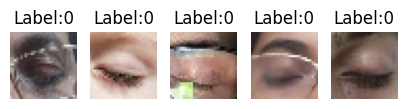

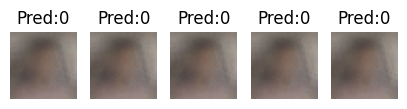

In [89]:
plt.figure(figsize=(5, 3))
for index in range(0, 5):
    plt.subplot(1, 5, index + 1)
    plt.imshow(test_images[index], cmap="binary")
    plt.title("Label:" + str(y_test[index]))
    plt.axis("off")
plt.show()
plt.figure(figsize=(5, 3))
for index in range(0, 5):
    plt.subplot(1, 5, index + 1)
    plt.title("Pred:" + str(y_pred_value[index]))
    plt.imshow(reconstructions[index], cmap="binary")
    plt.axis("off")    
plt.show()

# Conclusion


I tried to make the code in this notebook as flat and linear as possible, to make it easier to follow, but of course in practice you would want to wrap the code in nice reusable functions and classes. For example, you could try implementing your own PrimaryCapsuleLayer, and DenseRoutingCapsuleLayer classes, with parameters for the number of capsules, the number of routing iterations, whether to use a dynamic loop or a static loop, and so on. For an example a modular implementation of Capsule Networks based on TensorFlow, take a look at the CapsNet-TensorFlow project.

That's all for today, I hope you enjoyed this notebook!